# 🤗 Training with Diffusers

In recent months, it has become clear that diffusion models have taken the throne as the state-of-the-art generative models. Here, we will use Hugging Face's brand new [Diffusers](https://github.com/huggingface/diffusers) library to train a simple diffusion model. 

## Installing the dependencies

This notebook leverages the [🤗 Datasets](https://huggingface.co/docs/datasets/index) library to load and preprocess image datasets and the [🤗 Accelerate](https://huggingface.co/docs/accelerate/index) library to simplify training on any number of GPUs, with features like automatic gradient accumulation and tensorboard logging. Let's install them here:

In [1]:
import os

print(f"{os.getcwd()}")

/Users/richard/workspace/fictional-train


In [2]:
%%capture
#%pip install git+https://github.com/directedbit/diffusers.git#egg=diffusers\[training\]
#%pip install git+https://github.com/huggingface/diffusers.git#egg=diffusers\[training\]
%pip install diffusers[training]==0.2.2
%pip install accelerate
%pip install datasets
%pip install wandb
%pip install pytorch-fid

In [ ]:
# Then you need to install Git-LFS to upload your model checkpoints:
!sudo apt-get update
!sudo apt -qq install git-lfs

In [ ]:
%%capture
!git config --global user.email "rjdruce@hotmail.com"
!git config --global user.name "richard druce"
!git config --global credential.helper store

In [3]:
from huggingface_hub import notebook_login

s=notebook_login()
print(s)

Login successful
Your token has been saved to /Users/richard/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [4]:
import torch
from pytorch_fid.fid_score import calculate_fid_given_paths


device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
num_avail_cpus = len(os.sched_getaffinity(0))
num_workers = min(num_avail_cpus, 8)

fid_value = calculate_fid_given_paths(['path1','path2'],   #args.path,
                                      16, # args.batch_size,
                                      device, # device,
                                      2048,
                                      num_workers)


AttributeError: module 'os' has no attribute 'sched_getaffinity'

In [5]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: directedbit. Use `wandb login --relogin` to force relogin


True

## Config

For convenience, we define a configuration grouping all the training hyperparameters. This would be similar to the arguments used for a [training script](https://github.com/huggingface/diffusers/tree/main/examples).
Here we choose reasonable defaults for hyperparameters like `num_epochs`, `learning_rate`, `lr_warmup_steps`, but feel free to adjust them if you train on your own dataset. For example, `num_epochs` can be increased to 100 for better visual quality.

In [1]:
#from dataclasses import dataclass
import wandb
import torch
from diffusers import UNet2DModel
from diffusers.hub_utils import init_git_repo, push_to_hub

PROJECT_NAME = "celebs"
CHECKPOINT_PATH = './checkpoint.tar'
N_EPOCHS = 50
N_DATASET_PARTS = 11
INFERENCE_ONLY = False
TEST_RUN = True

epoch = 0
cur_dataset_part = 1

# 1. Start a new run
wandb.init(project=PROJECT_NAME, resume=True)


config = wandb.config

# 2. Save model inputs and hyperparameters
#config = wandb.config
config.image_size = 128  # the generated image resolution
config.train_batch_size = 16
config.eval_batch_size = 16  # how many images to sample during evaluation
config.gradient_accumulation_steps = 1
# learning rate should be 1 / dataset / epochs? = 1 / 200000 / 50 = 
config.learning_rate = 1e-6
config.lr_warmup_steps = 1000
config.save_image_epochs = 5 
config.save_model_epochs = 5
config.evaluation_timesteps = 1000
#config.mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
config.mixed_precision = 'no'
config.output_dir = 'ddpm-celeb-128'  # the model namy locally and on the HF Hub

config.push_to_hub = False  # whether to upload the saved model to the HF Hub
config.hub_private_repo = False  
config.overwrite_output_dir = True  # overwrite the old model when re-running the notebook
config.seed = 0
config.from_pretrained = False
config.split = ""
#config.dataset_name = "data/img_align_celeba"
config.dataset_name = "beans"
config._global_step = 0



if TEST_RUN:
    N_EPOCHS = 2
    N_DATASET_PARTS = 1
    config.evaluation_timesteps = 10
    config.split="[1:32]"
    print(f'epochs= {N_EPOCHS}, eval_timesteps={config.evaluation_timesteps} split={config.split}')
    config.output_dir = "test-" + config.output_dir



if config.from_pretrained:
    print('using pre-trained model')
    model = UNet2DModel.from_pretrained(config.output_dir)
    #
    repo = init_git_repo(config, at_init=True)
    push_to_hub(config, model, repo, commit_message=f"Checkpoint", blocking=True)
    
    #model = UNet2DModel.from_pretrained(f'rdruce/{config.output_dir}')
    #model = UNet2DModel.from_pretrained("google/ddpm-church-256")
else:
    model = UNet2DModel(
        sample_size=config.image_size,  # the target image resolution
        in_channels=3,  # the number of input channels, 3 for RGB images
        out_channels=3,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
        down_block_types=( 
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D", 
            "DownBlock2D", 
            "DownBlock2D", 
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ), 
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D", 
            "UpBlock2D", 
            "UpBlock2D", 
            "UpBlock2D"  
          ),
    )

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)



# if wandb.run.resumed:
#     print('resuming run')
#     checkpoint = torch.load(wandb.restore(CHECKPOINT_PATH))
#     epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
#     config._global_step = checkpoint['global_step']
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: directedbit. Use `wandb login --relogin` to force relogin


epochs= 2, eval_timesteps=10 split=[1:32]


## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our image dataset.

In this case, the [Butterflies dataset](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) is hosted remotely, but you can load a local [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) as shown in the commets below. 

In [2]:
from datasets import load_dataset, concatenate_datasets




# config.dataset = "imagefolder"
# dataset = load_dataset("imagefolder", dtaa)

# Feel free to try other datasets from https://hf.co/huggan/ too! 
# Here's is a dataset of flower photos:
#config.dataset = "huggan/flowers-102-categories"
#dataset = load_dataset(config.dataset, split="train") #[1:32]") # split='train[1:32]'

#dataset = load_dataset(config.dataset_name, split=f"train{config.split}") # split='train[1:32]'
def my_load_dataset(name, part, split, n_parts):
    sp = f'train{split}'
    dn = name
    if n_parts > 1:
        dn = f'{dn}/{part}'
    print(f'{dn} split={sp}')
    return load_dataset(dn, split=sp)
dataset = my_load_dataset(config.dataset_name, cur_dataset_part, config.split, N_DATASET_PARTS)

#config.dataset = "butterflies"
#leaves = load_dataset("beans", split="train")
#butterflies = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
#dataset = concatenate_datasets([leaves, butterflies])
#dataset = butterflies

# Or just load images from a local folder!
# config.dataset = "imagefolder"
# dataset = load_dataset(config.dataset, data_dir="/content/data/", split="train")

dataset


beans split=train[1:32]


Using custom data configuration default
Reusing dataset beans (/Users/richard/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 31
})

The dataset contains several extra `features` (columns), but the one that we're interested in is `image`:

Since the [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) feature loads the images with PIL, we can easily look at a few examples:

/var/folders/v0/xn61xw354y15qgvlbcg6q6rc0000gp/T/ipykernel_5141/3727589697.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


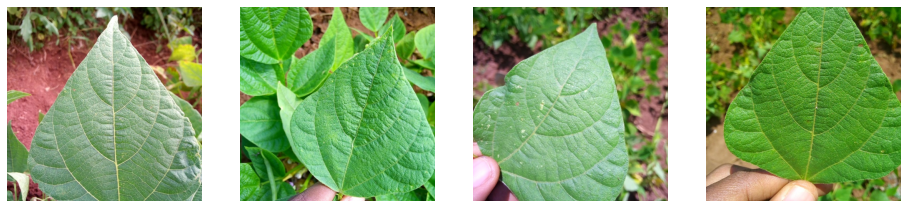

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()



The images in the dataset are all different, so we need to preprocess them first:
* `Resize` makes the images conform to a square resolution of `config.image_size`
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `Normalize` is important to rescale the pixel values into a `[-1, 1]` range (which our model will expect).

In [4]:


from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

🤗 Datasets offer a handy `set_transform()` method to apply the image transformations on the fly during training:

In [5]:


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)



In [6]:
from PIL import Image
import torch
from torchvision import transforms

#now check shape against my own initialising image
pp = transforms.Compose(
            [
                transforms.Resize((config.image_size, config.image_size )),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ])
test_face = Image.open("./testface.jpg")
test_face = pp(test_face.convert("RGB"))
test_face = torch.unsqueeze(test_face, 0)
print(test_face.shape)
# now make it the size of the sample batch
test_faces = torch.cat(config.eval_batch_size*[test_face],dim=0)
print(f'GPU available: {torch.cuda.is_available()}')
print(test_faces.shape)

torch.Size([1, 3, 128, 128])
GPU available: False
torch.Size([16, 3, 128, 128])


Let's see what they look like now

/var/folders/v0/xn61xw354y15qgvlbcg6q6rc0000gp/T/ipykernel_5141/2253459887.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/v0/xn61xw354y15qgvlbcg6q6rc0000gp/T/ipykernel_5141/2253459887.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


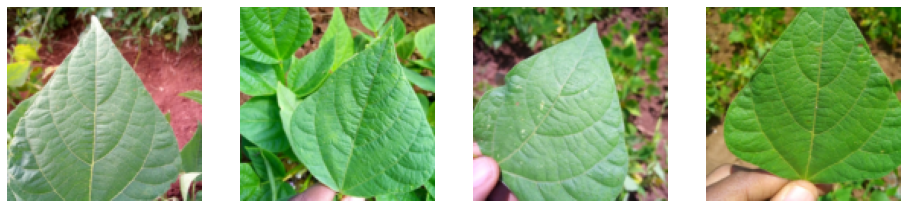

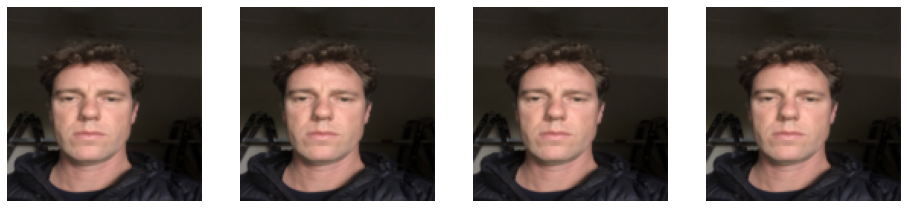

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

fig2, axs2 = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(test_faces[:4]):
    axs2[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs2[i].set_axis_off()
fig2.show()

Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.

In [8]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Defining the diffusion model

Here we set up our diffusion model. Diffusion models are neural networks that are trained to predict slightly less noisy images from a noisy input. At inference, they can be used to iteratively transform a random noise to generate an image:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Don't worry too much about the math if you're not familiar with it, the import part to remember is that our model corresponds to the arrow $p_{\theta}(x_{t-1}|x_{t})$ (which is a fancy way of saying: predict a slightly less noisy image).

The interesting part is that it's really easy to add some noise to an image, so the training can happen in a semi-supervised fashion as follows:
1. Take an image from the training set.
2. Apply to it some random noise $t$ times (this will give the $x_{t-1}$ and the $x_{t}$ in the figure above).
3. Give this noisy image to the model along with the value of $t$.
4. Compute a loss from the output of the model and the noised image $x_{t-1}$.

Then we can apply gradient descent and repeat this process multiple times.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size. 
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):


Let's get a sample image from our dataset and pass it into our model. We just need to add a batch dimension:

In [9]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

# And let's check the output is a tensor of the same exact shape:

print('Output shape:', model(sample_image, timestep=0)["sample"].shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


Great!

Note that our model takes in the (noisy) image and also the current time-step (as we saw before in the training overview). That time-step information is converted for the model using a sinusoidal positional embedding, similar to what Transformer models often do.

Now that we have our model, we just need an object to *add noise to an image*. This is done by the **schedulers** in the `diffusers` library.

## Defining the noise scheduler

Depending on the diffusion algorithm you want to use, the way images are noised is slightly different. That's why 🤗 Diffusers contains different scheduler classes which each define the algorithm-specific diffusion steps. Here we are going to use the `DDPMScheduler` which corresponds to the training denoising and training algorithm proposed in [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

In [10]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, tensor_format="pt")

Let's see how this noise scheduler works: it takes a batch of images from the trainng set (here we will reuse the batch of one image `sample_image` form before), a batch of random noise of the same shape and the timesteps for each image (which correspond to the number of times we want to apply noise to each image):

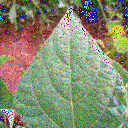

In [11]:
import torch
from PIL import Image
from IPython.display import display

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

img = Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
wandb.log({'noise_added': wandb.Image(img)})
display(img)

In the DDPM algorithm, the training objective of the model is then to be able to predict the noise we used in `noise_scheduler.add_noise`, so the loss at this step would be:

In [12]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps)["sample"]
loss = F.mse_loss(noise_pred, noise)

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk. 

In [13]:
#from diffusers import DDPMPipeline

import math
import torch

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline, test_images, steps=1000):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    print(f'evaluate steps {steps}')
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed), #random seed for images
        torch_device= 'cuda' if torch.cuda.is_available() else 'cpu',
        image=test_images, steps=steps
    )["sample"]

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    wandb.log({"evaluation": wandb.Image(image_grid), "steps": steps})
    
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")
    

In [14]:
import torch

from diffusers import DDPMPipeline
from tqdm.auto import tqdm


class ImageDDPMPipeline(DDPMPipeline):
    def __init__(self, unet, scheduler):
        super().__init__(unet, scheduler)

    @torch.no_grad()
    def __call__(self, batch_size=1, generator=None, torch_device=None, output_type="pil", image=None, steps=1000):
        if torch_device is None:
            torch_device = "cuda"
        print(f'running on {torch_device}')

        self.unet.to(torch_device)
        
        # Sample gaussian noise if no image
        if image == None:
            print('generating start image randomly')
            image = torch.randn(
                (batch_size, self.unet.in_channels, self.unet.sample_size, self.unet.sample_size),
                generator=generator,
            )
        else:
            print('using provided start image')
        image = image.to("cuda")
        print(f'GPU available: {torch.cuda.is_available()}')
        

        # set step values
        self.scheduler.set_timesteps(steps)
        print(f'scheduler timesteps = {steps}')

        for t in tqdm(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(image, t)["sample"]

            # 2. compute previous image: x_t -> t_t-1
            image = self.scheduler.step(model_output, t, image)["prev_sample"]

        image = (image / 2 + 0.5).clamp(0, 1)
        # permute is to swap the tensor spots ? Why? 
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image}

With this in end, we can group all together and write our training function. This just wraps the training step we saw in the previous section in a loop, using Accelerate for easy TensorBoard logging, gradient accumulation, mixed precision training and multi-GPUs or TPU training.

In [15]:
from accelerate import Accelerator
from diffusers.hub_utils import init_git_repo, push_to_hub

from tqdm.auto import tqdm
import os


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, test_faces):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo = init_git_repo(config, at_init=True)
        accelerator.init_trackers(PROJECT_NAME)

    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, batch in enumerate(train_dataloader):
        clean_images = batch['images']
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps)["sample"]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            wandb.log({"loss": loss})
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": config._global_step}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=config._global_step)
        config._global_step += 1




## Let's train!

Let's launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

aaaaaaaaaaaaaaaaaaaaaaaaa

In [16]:
import torch
from accelerate import notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup

# 3. Log gradients and model parameters
wandb.watch(model)

while epoch < N_EPOCHS:
    for i in range(N_DATASET_PARTS):
        print(f'starting dataset {cur_dataset_part}')
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

        

        #And a cosine learning rate schedule:
        lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_dataloader) * N_EPOCHS),)

        print(len(train_dataloader))
        args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, test_faces)
        notebook_launcher(train_loop, args, num_processes=1)
        
        #save our checkpoint
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'global_step': config._global_step,
        'cur_dataset_part': cur_dataset_part,
        }, CHECKPOINT_PATH)
        wandb.save(CHECKPOINT_PATH)
        
        # load next dataset 
        cur_dataset_part += 1
        if cur_dataset_part > N_DATASET_PARTS:
            print('finished full dataset, restarting')
            cur_dataset_part = 1
        #dataset = load_dataset(config.dataset_name, split=f"train{config.split}") # split='train[1:32]'
        
        dataset = my_load_dataset(config.dataset_name, cur_dataset_part, config.split, N_DATASET_PARTS)
        print('datset loaded')

        #transform dataset
        dataset.set_transform(transform)

    print('completed one full dataset iteration')    
    # After each iteration optionally sample some demo images with evaluate() and save the model
    
    if (epoch) % config.save_image_epochs == 0 or epoch == N_EPOCHS - 1:
        pipeline = ImageDDPMPipeline(unet=model, scheduler=noise_scheduler)
        evaluate(config, epoch, pipeline, None, steps=config.evaluation_timesteps)    

    if (epoch) % config.save_model_epochs == 0 or epoch == N_EPOCHS - 1:
        if config.push_to_hub:
            print(f'pushing model to hub')
            push_to_hub(config, model, repo, commit_message=f"Epoch {epoch}", blocking=True)
    # always save
    print(f'saving model to {config.output_dir}')
    # if not TEST_RUN:
    #    model.save_pretrained(config.output_dir)
    epoch += 1

print('finished')


starting dataset 1
2
Launching training on CPU.


  0%|          | 0/2 [00:00<?, ?it/s]

Let's have a look at the final image grid produced by the trained diffusion model:

In [ ]:
# commented out while running inference
import glob

if not INFERENCE_ONLY:
    sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
    Image.open(sample_images[4])
else:
    print('not generating sample images from training')

In [ ]:
from diffusers import UNet2DModel
from accelerate import Accelerator
from diffusers import DDPMScheduler
import os
import torch
from PIL import Image
from IPython.display import display


# load the new model
model = UNet2DModel.from_pretrained('ddpm-flowers-128-2/unet').cuda()


noise_scheduler = DDPMScheduler(num_train_timesteps=1000, tensor_format="pt")

for k in range (1,10):
    wandb.init("leaves")
    wandb.log({"k timestep / 10": k})
    noise = torch.randn(test_faces.shape)
    timesteps = torch.LongTensor([k * 100])
    noisy_faces = noise_scheduler.add_noise(test_faces, noise, timesteps)

    img = Image.fromarray(((noisy_faces.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
    wandb.log({'SDE noise_added': wandb.Image(img)})
    display(img)

    noisy_faces = noisy_faces.to("cuda")

    # pipe = pipeline('', 'ddpm-flowers-128/unet')
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="wandb",
        logging_dir=os.path.join(config.output_dir, "logs"))
    pipeline = ImageDDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    for i in range(1,1000,100):
        evaluate(config, 1 ,pipeline, noisy_faces, steps=i)


Not bad! There's room for improvement of course, so feel free to play with the hyperparameters, model definition and image augmentations 🤗

If you've chosen to upload the model to the Hugging Face Hub, its repository should now look like so: 
https://huggingface.co/anton-l/ddpm-butterflies-128

If you want to dive deeper into the code, we also have more advanced training scripts with features like Exponential Moving Average of model weights here: 

https://github.com/huggingface/diffusers/tree/main/examples